# Start

In [35]:
# Install Hugging Face + PyTorch dependencies (run once per fresh runtime)
# %pip install -q transformers datasets accelerate torch emoji


In [36]:
# START

import json
import os
import platform
import re
import shutil
import tempfile
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
torch.backends.cudnn.benchmark = True
torch.set_num_threads(1)
import torch.nn.functional as F
import transformers
import datasets
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    pipeline,
)

import mlflow
import mlflow.pytorch
from mlflow.models import infer_signature

import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
)

# Disable tqdm/rich progress tables to keep notebook output clean
os.environ["DISABLE_TQDM"] = "1"
os.environ["HF_DISABLE_PROGRESS_BAR"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

MLFLOW_EXPERIMENT_NAME = "Model_DistilBERT_english"
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"   #"distilbert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

EVALUATION_ARTIFACT_SUBDIR = "evaluation"
MODEL_ARTIFACT_DIRNAME = "distilbert_model_package"
INFERENCE_EXAMPLE = {"text": ["I love how friendly this app is!"]}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    torch.cuda.set_device(0)

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("PyTorch version:", torch.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Training device:", DEVICE)

import torch, os, platform
print(torch.__version__, torch.version.cuda)
print("CUDA dispo :", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Transformers version: 4.57.1
Datasets version: 4.4.1
PyTorch version: 2.5.1+cu121
Scikit-learn version: 1.7.2
Training device: cuda
2.5.1+cu121 12.1
CUDA dispo : True
NVIDIA GeForce RTX 4060 Laptop GPU


# DATA READING

In [37]:
# DATA READING
df = pd.read_csv(
    "../../sentiment140/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None,
    names=["sentiment", "id", "date", "query", "user", "tweet"],
)

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [38]:
# Keep only sentiment + tweet

df = df[["sentiment", "tweet"]]

# Stratified sampling to have tweets of the two sentiments
df_negatifs = df[df["sentiment"] == 0].sample(20000, random_state=42)
df_positifs = df[df["sentiment"] == 4].sample(20000, random_state=42)

# So we get a sample of 10% of the original dataset
df = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)

# Map labels 4 -> 1 for binary classification
df["sentiment"] = df["sentiment"].replace(4, 1)

df.head()


,sentiment,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...


In [39]:
# Class balance check
df["sentiment"].value_counts()


sentiment
0    20000
1    20000
Name: count, dtype: int64

# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

Compared to the preprocessing of tweets made during the application of logistic regression, the steps written in red have been removed, and the steps in green are repeated or added for this time.


<span style="color:red">- Lowercase</span>

<span style="color:red">- Convert emoticons → words</span>

<span style="color:red">- Convert emojis → words</span>

<span style="color:red">- Remove URLs, mentions, hashtags</span>


In [40]:
# CLEANING TEXT – passthrough (only whitespace trimming)

def normalize_tweet(t: str) -> str:
    return re.sub(r"\s+", " ", t.strip())


## Spliting

In [41]:
# Spliting – same logic as in Model 2

texts = df["tweet"].astype(str).tolist()
labels = df["sentiment"].astype("float32").to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp,
)

print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))


Train size: 32000 Val size: 4000 Test size: 4000


In [42]:
# Normalize tweets after splitting to avoid leakage

def _normalize_batch(texts: List[str]) -> List[str]:
    return [normalize_tweet(t) for t in texts]

X_train_clean = _normalize_batch(X_train)
X_val_clean = _normalize_batch(X_val)
X_test_clean = _normalize_batch(X_test)

y_train_int = y_train.astype(int)
y_val_int = y_val.astype(int)
y_test_int = y_test.astype(int)


In [43]:
# Convert splits to Hugging Face Dataset objects

train_dataset = Dataset.from_dict({"text": X_train_clean, "label": y_train_int})
val_dataset = Dataset.from_dict({"text": X_val_clean, "label": y_val_int})
test_dataset = Dataset.from_dict({"text": X_test_clean, "label": y_test_int})

train_dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 32000
})

# DISTILBERT

In [44]:
# Tokenization with DistilBERT tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

tokenized_train = train_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")


Map: 100%|██████████| 4000/4000 [00:00<00:00, 12758.88 examples/s]


In [45]:
# Utility helpers for MLflow logging and artifact export

def create_confusion_matrix_figure(y_true: np.ndarray, y_pred: np.ndarray):
    fig, ax = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix - DistilBERT")
    return fig


def create_roc_curve_figure(y_true: np.ndarray, y_scores: np.ndarray):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve - DistilBERT")
    ax.legend(loc="lower right")
    return fig, roc_auc


def create_training_loss_figure(loss_history: List[Dict[str, float]]):
    if not loss_history:
        return None, None
    loss_df = pd.DataFrame(loss_history).dropna(subset=["step", "loss"])
    if loss_df.empty:
        return None, None
    loss_df = loss_df.sort_values("step")
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(loss_df["step"], loss_df["loss"], marker="o", linewidth=1, markersize=3)
    ax.set_xlabel("Training step")
    ax.set_ylabel("Loss")
    ax.set_title("Training loss evolution")
    ax.grid(True, linestyle="--", alpha=0.3)
    return fig, loss_df


def log_and_display_figure(fig, artifact_name, artifact_dir=EVALUATION_ARTIFACT_SUBDIR):
    mlflow.log_figure(fig, f"{artifact_dir}/{artifact_name}")
    display(fig)
    plt.close(fig)


def build_requirements_list() -> List[str]:
    return [
        f"torch=={torch.__version__}",
        f"transformers=={transformers.__version__}",
        f"datasets=={datasets.__version__}",
        f"scikit-learn=={sklearn.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"mlflow=={mlflow.__version__}",
        f"seaborn=={sns.__version__}",
    ]


def write_environment_files(target_dir: Path, requirements: List[str]) -> None:
    requirements_path = target_dir / "requirements.txt"
    requirements_path.write_text("".join(requirements) + "")

    python_version = platform.python_version()
    conda_lines = [
        "name: distilbert_env",
        "channels:",
        "  - defaults",
        "  - conda-forge",
        "dependencies:",
        f"  - python={python_version}",
        "  - pip",
        "  - pip:",
    ] + [f"      - {req}" for req in requirements]
    (target_dir / "conda.yaml").write_text("".join(conda_lines) + "")

    python_env_lines = [
        f"python: {python_version}",
        "build_dependencies:",
        "  - pip",
        "  - setuptools",
        "  - wheel",
        "dependencies:",
    ] + [f"  - {req}" for req in requirements]
    (target_dir / "python_env.yaml").write_text("".join(python_env_lines) + "")


def save_and_log_model_artifacts(trainer: Trainer, tokenizer: AutoTokenizer, input_example: Dict[str, List[str]]) -> None:
    artifact_dir = Path(MODEL_ARTIFACT_DIRNAME)
    if artifact_dir.exists():
        shutil.rmtree(artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    hf_model_dir = artifact_dir / "hf_model"
    trainer.save_model(hf_model_dir)

    tokenizer_dir = artifact_dir / "tokenizer"
    tokenizer.save_pretrained(tokenizer_dir)

    preprocessing_payload = {
        "steps": [
            "strip surrounding whitespace",
            "collapse repeated whitespace into a single space",
        ],
        "regex_normalization": r"\s+",
    }
    with open(artifact_dir / "preprocessing_pipeline.json", "w") as fp:
        json.dump(preprocessing_payload, fp, indent=2)

    model_pkl_path = artifact_dir / "model.pkl"
    torch.save(trainer.model.state_dict(), model_pkl_path)

    with open(artifact_dir / "input_example.json", "w") as fp:
        json.dump(input_example, fp, indent=2)

    serving_payload = {"inputs": input_example["text"][0]}
    with open(artifact_dir / "serving_input_example.json", "w") as fp:
        json.dump(serving_payload, fp, indent=2)

    requirements = build_requirements_list()
    write_environment_files(artifact_dir, requirements)

    mlflow.log_artifacts(str(artifact_dir), artifact_path="model_package")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenized_example = tokenizer(
        input_example["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt",
    )
    tokenized_example = {k: v.to(device) for k, v in tokenized_example.items()}
    tokenized_np = {k: v.detach().cpu().numpy() for k, v in tokenized_example.items()}

    trainer.model.to(device)
    trainer.model.eval()
    with torch.no_grad():
        logits = trainer.model(**tokenized_example).logits.detach().cpu().numpy()
    signature = infer_signature(tokenized_np, logits)

    # Reload a clean FP32 model from the saved HF weights to avoid AMP pickling issues
    hf_logged_model = AutoModelForSequenceClassification.from_pretrained(
        hf_model_dir,
        num_labels=trainer.model.config.num_labels,
    )
    hf_logged_model.to("cpu")

    mlflow.pytorch.log_model(
        pytorch_model=hf_logged_model,
        name="distilbert_pytorch_model",
        signature=signature,
    )

    trainer.model.to(device)


In [46]:
# Prepare training set (use all available samples)

training_dataset = tokenized_train
print(f"Using all {len(training_dataset)} training samples")



Using all 32000 training samples


/tmp/ipykernel_2813/3379452505.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.4809, 'grad_norm': 26.577884674072266, 'learning_rate': 9.2e-08, 'epoch': 0.025}
{'loss': 1.4177, 'grad_norm': 22.008031845092773, 'learning_rate': 1.92e-07, 'epoch': 0.05}
{'loss': 1.221, 'grad_norm': 44.14396667480469, 'learning_rate': 2.92e-07, 'epoch': 0.075}
{'loss': 1.1729, 'grad_norm': 26.316850662231445, 'learning_rate': 3.92e-07, 'epoch': 0.1}
{'loss': 1.2027, 'grad_norm': 24.13399314880371, 'learning_rate': 4.92e-07, 'epoch': 0.125}
{'loss': 1.096, 'grad_norm': 5.766862869262695, 'learning_rate': 5.920000000000001e-07, 'epoch': 0.15}
{'loss': 1.0421, 'grad_norm': 29.41632843017578, 'learning_rate': 6.92e-07, 'epoch': 0.175}
{'loss': 0.9621, 'grad_norm': 14.639702796936035, 'learning_rate': 7.920000000000001e-07, 'epoch': 0.2}
{'loss': 0.9507, 'grad_norm': 17.782276153564453, 'learning_rate': 8.920000000000001e-07, 'epoch': 0.225}
{'loss': 0.874, 'grad_norm': 21.255970001220703, 'learning_rate': 9.92e-07, 'epoch': 0.25}
{'loss': 0.7203, 'grad_norm': 15.1315574645996

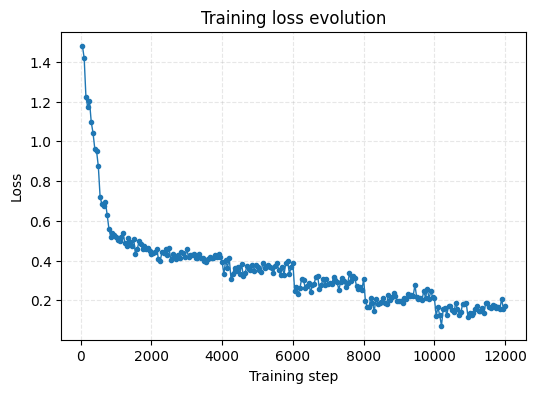

{'eval_loss': 0.4778115749359131, 'eval_accuracy': 0.82175, 'eval_precision': 0.8180919426594168, 'eval_recall': 0.8275, 'eval_f1': 0.8227690778026349, 'eval_runtime': 2.7951, 'eval_samples_per_second': 1431.083, 'eval_steps_per_second': 89.443, 'epoch': 6.0}
{'eval_loss': 0.45502910017967224, 'eval_accuracy': 0.8235, 'eval_precision': 0.8209325396825397, 'eval_recall': 0.8275, 'eval_f1': 0.8242031872509961, 'eval_runtime': 3.1953, 'eval_samples_per_second': 1251.83, 'eval_steps_per_second': 78.239, 'epoch': 6.0}
Test accuracy: 0.8235
Test precision: 0.8209
Test recall: 0.8275
Test F1-score: 0.8242


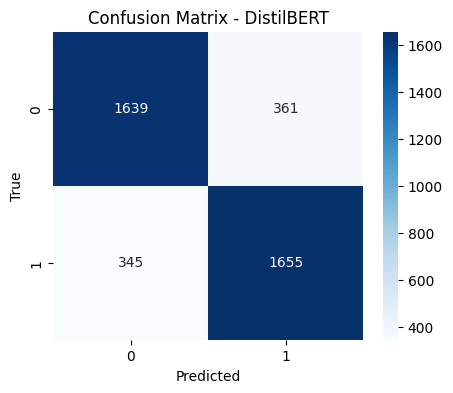

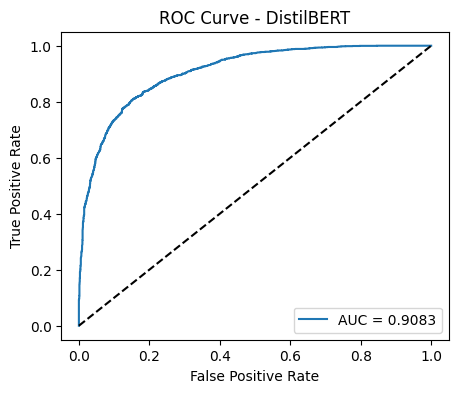

2025/11/24 10:24:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/24 10:24:18 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [47]:
# Fine-tune distilbert-base-uncased with the Trainer API

import inspect

TRAINING_ARGS_PARAMS = set(inspect.signature(TrainingArguments.__init__).parameters.keys())

def _add_if_supported(kwargs, name, value):
    if name in TRAINING_ARGS_PARAMS:
        kwargs[name] = value
        return True
    return False

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


with mlflow.start_run(run_name="distilbert_parent"):
    mlflow.log_param("device", DEVICE)
    mlflow.log_param("device", DEVICE)
    mlflow.log_params(
        {
            "model_name": MODEL_NAME,
            "max_length": MAX_LENGTH,
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "train_batch_size": BATCH_SIZE,
            "weight_decay": WEIGHT_DECAY,
            "warmup_ratio": WARMUP_RATIO,
        }
    )

    training_kwargs = {"output_dir": "./distilbert_outputs"}
    steps_per_epoch = max(len(training_dataset) // BATCH_SIZE, 1)
    warmup_steps = int(WARMUP_RATIO * steps_per_epoch * EPOCHS)

    has_eval_strategy = _add_if_supported(training_kwargs, "evaluation_strategy", "epoch")
    has_eval_strategy = has_eval_strategy or _add_if_supported(training_kwargs, "eval_strategy", "epoch")
    if not has_eval_strategy:
        _add_if_supported(training_kwargs, "evaluate_during_training", True)
        _add_if_supported(training_kwargs, "eval_steps", steps_per_epoch)

    has_save_strategy = _add_if_supported(training_kwargs, "save_strategy", "epoch")
    if not has_save_strategy:
        _add_if_supported(training_kwargs, "save_steps", steps_per_epoch)

    if has_eval_strategy:
        _add_if_supported(training_kwargs, "load_best_model_at_end", True)
        _add_if_supported(training_kwargs, "metric_for_best_model", "f1")

    _add_if_supported(training_kwargs, "learning_rate", LEARNING_RATE)
    _add_if_supported(training_kwargs, "num_train_epochs", EPOCHS)
    _add_if_supported(training_kwargs, "weight_decay", WEIGHT_DECAY)
    _add_if_supported(training_kwargs, "logging_steps", 50)
    _add_if_supported(training_kwargs, "seed", 42)
    _add_if_supported(training_kwargs, "disable_tqdm", True)
    _add_if_supported(training_kwargs, "fp16", True)
    _add_if_supported(training_kwargs, "dataloader_num_workers", 4)
    _add_if_supported(training_kwargs, "dataloader_pin_memory", True)
    _add_if_supported(training_kwargs, "warmup_ratio", WARMUP_RATIO)
    _add_if_supported(training_kwargs, "warmup_steps", warmup_steps)
    _add_if_supported(training_kwargs, "per_device_train_batch_size", BATCH_SIZE) or _add_if_supported(training_kwargs, "per_gpu_train_batch_size", BATCH_SIZE)
    _add_if_supported(training_kwargs, "per_device_eval_batch_size", BATCH_SIZE) or _add_if_supported(training_kwargs, "per_gpu_eval_batch_size", BATCH_SIZE)
    _add_if_supported(training_kwargs, "no_cuda", DEVICE != "cuda")
    _add_if_supported(training_kwargs, "report_to", [])

    training_args = TrainingArguments(**training_kwargs)

    callbacks_list = []
    if has_eval_strategy:
        callbacks_list.append(EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0))

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks_list,
    )

    train_result = trainer.train()
    mlflow.log_metric("train_loss", train_result.training_loss)

    loss_history = [
        {
            "step": log_entry.get("step"),
            "epoch": log_entry.get("epoch"),
            "loss": log_entry.get("loss"),
        }
        for log_entry in trainer.state.log_history
        if "loss" in log_entry
    ]
    loss_fig, loss_df = create_training_loss_figure(loss_history)
    if loss_fig is not None:
        log_and_display_figure(loss_fig, "training_loss.png")
        if loss_df is not None and not loss_df.empty:
            tmp_dir = Path(tempfile.mkdtemp())
            csv_path = tmp_dir / "training_loss.csv"
            loss_df.to_csv(csv_path, index=False)
            mlflow.log_artifact(str(csv_path), artifact_path=EVALUATION_ARTIFACT_SUBDIR)
            shutil.rmtree(tmp_dir, ignore_errors=True)

    val_metrics = trainer.evaluate(tokenized_val)
    mlflow.log_metrics(
        {
            "val_loss": val_metrics.get("eval_loss"),
            "val_accuracy": val_metrics.get("eval_accuracy"),
            "val_precision": val_metrics.get("eval_precision"),
            "val_recall": val_metrics.get("eval_recall"),
            "val_f1": val_metrics.get("eval_f1"),
        }
    )

    test_metrics = trainer.evaluate(tokenized_test)
    mlflow.log_metrics(
        {
            "test_loss": test_metrics.get("eval_loss"),
            "test_accuracy": test_metrics.get("eval_accuracy"),
            "test_precision": test_metrics.get("eval_precision"),
            "test_recall": test_metrics.get("eval_recall"),
            "test_f1": test_metrics.get("eval_f1"),
        }
    )

    test_predictions = trainer.predict(tokenized_test)
    y_true = test_predictions.label_ids
    y_pred = np.argmax(test_predictions.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    acc = accuracy_score(y_true, y_pred)
    print(f"Test accuracy: {acc:.4f}")
    print(f"Test precision: {precision:.4f}")
    print(f"Test recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    probs = F.softmax(torch.from_numpy(test_predictions.predictions), dim=1).numpy()
    fig_cm = create_confusion_matrix_figure(y_true, y_pred)
    log_and_display_figure(fig_cm, "confusion_matrix.png")

    fig_roc, roc_auc = create_roc_curve_figure(y_true, probs[:, 1])
    log_and_display_figure(fig_roc, "roc_curve.png")
    mlflow.log_metric("test_auc", roc_auc)

    save_and_log_model_artifacts(trainer, tokenizer, INFERENCE_EXAMPLE)


# Testing on hard tweets

In [51]:
hard_tweets_dataset = [
    # Sarcasme / Ironie
    {"tweet": "Great job @AirParadis, another ‘on-time’ departure… only 3 hours late. Truly impressive 🙃", "label": "negative"},
    {"tweet": "Loved waiting at the gate for an eternity. Really, I had nothing better to do today 😂", "label": "negative"},
    {"tweet": "Oh wow @AirParadis offered me water after canceling my flight. I feel so blessed 😒", "label": "negative"},
    {"tweet": "Amazing! My baggage is on a trip to Paris while I'm stuck in Madrid. Living the dream!", "label": "negative"},
    {"tweet": "Thanks for the unforgettable experience, @AirParadis… I wish I could forget it though.", "label": "negative"},

    # Ambiguïté volontaire
    {"tweet": "This flight was… something. Not sure what, but definitely something.", "label": "mixed"},
    {"tweet": "I guess the flight could've been worse… but also could've been much better.", "label": "mixed"},
    {"tweet": "Not exactly thrilled, but not angry either. Just… here.", "label": "mixed"},
    {"tweet": "Honestly, I'm too tired to decide if today was a good or bad day with @AirParadis.", "label": "mixed"},
    {"tweet": "The service was okay-ish. Whatever that means.", "label": "mixed"},

    # Double négation / Sentiment inversé
    {"tweet": "I'm not saying the flight was bad, but I'm not saying it was good either.", "label": "mixed"},
    {"tweet": "I can't say I didn't enjoy some parts of the trip.", "label": "positive"},
    {"tweet": "Not unhappy about the delay, just confused.", "label": "mixed"},
    {"tweet": "The flight wasn’t not comfortable… if that makes sense?", "label": "mixed"},
    {"tweet": "I wouldn’t say I don’t recommend @AirParadis.", "label": "positive"},

    # Mixed feelings très complexes
    {"tweet": "Amazing landing, awful takeoff, nice staff, terrible food. How am I supposed to feel?", "label": "mixed"},
    {"tweet": "Loved the entertainment, hated the turbulence. Mixed package.", "label": "mixed"},
    {"tweet": "My kids had fun on the plane, but I didn’t. Fun for them, stress for me.", "label": "mixed"},
    {"tweet": "The upgrade was cool, but only because the original seat was broken.", "label": "mixed"},
    {"tweet": "They lost my bag, but the crew was so kind I couldn't even be mad.", "label": "mixed"},

    # Positif qui paraît négatif / Négatif qui paraît positif
    {"tweet": "The flight felt endless, but at least I caught up on all my podcasts.", "label": "mixed"},
    {"tweet": "Seat wouldn’t recline, but hey, my posture never felt better 😅", "label": "mixed"},
    {"tweet": "So tired after this flight… probably the most relaxing chaos I’ve ever experienced.", "label": "mixed"},
    {"tweet": "The delay gave me time to think. Not sure if that’s good or bad.", "label": "mixed"},
    {"tweet": "At least I didn’t die, so I guess that's a win? Thanks @AirParadis?", "label": "mixed"},

    # Émotions non explicites / implicites
    {"tweet": "I don’t even have the energy to complain anymore.", "label": "negative"},
    {"tweet": "It happened again. Just… again. @AirParadis", "label": "negative"},
    {"tweet": "I’m not mad. I’m disappointed. There’s a difference.", "label": "negative"},
    {"tweet": "No words. Just no words.", "label": "negative"},
    {"tweet": "Sometimes, silence says everything. Today is one of those days.", "label": "negative"},

    # Sarcasme positif (pièges)
    {"tweet": "Wow, @AirParadis actually took off on time. I must be dreaming!", "label": "positive"},
    {"tweet": "Didn’t get bumped from my seat today. Is this real life?", "label": "positive"},
    {"tweet": "Flight attendants smiled today. What a historical moment!", "label": "positive"},
    {"tweet": "A whole flight without issues? Someone check if the universe is glitching.", "label": "positive"},

    # Positif en surface mais fond négatif
    {"tweet": "So happy that my flight is delayed again… gives me time to contemplate my life choices.", "label": "negative"},
    {"tweet": "Nice to see @AirParadis being consistent… consistently disappointing.", "label": "negative"},
    {"tweet": "Lovely how the announcements tell us nothing useful. A mystery trip!", "label": "negative"},
    {"tweet": "Thanks for the free snack. Pity I won't get home today, though.", "label": "negative"},

    # Ambigus profonds
    {"tweet": "Honnêtement, je devrais être en colère, mais je ne ressens plus rien.", "label": "negative"},
    {"tweet": "Je crois que j’aurais aimé ce vol si j’avais vécu une autre journée.", "label": "mixed"},
]


# Utilitaire pour lancer le modèle fine-tuné sur les listes définies
trainer.model.eval()
inference_device = 0 if DEVICE == "cuda" else -1
sentiment_pipeline = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    device=inference_device,
)

LABEL_MAP = {"POSITIVE": "positive", "NEGATIVE": "negative", "LABEL_1": "positive", "LABEL_0": "negative"}
VALID_EVAL_LABELS = {"positive", "negative"}

def predict_hard_dataset(name: str, dataset):
    if not dataset:
        print(f"{name}: aucune donnée à tester.")
        return

    texts = [row.get("tweet", "") for row in dataset]
    labels = [str(row.get("label", "")).lower() for row in dataset]
    normalized = [normalize_tweet(t) for t in texts]

    predictions = sentiment_pipeline(
        normalized,
        batch_size=BATCH_SIZE,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
    )

    rows = []
    for raw_tweet, expected, pred in zip(texts, labels, predictions):
        predicted_label = LABEL_MAP.get(pred["label"], pred["label"]).lower()
        rows.append(
            {
                "tweet": raw_tweet,
                "label_attendue": expected or "(non spécifié)",
                "prediction": predicted_label,
                "score": round(pred["score"], 4),
            }
        )

    df = pd.DataFrame(rows)
    display(df)

    eval_rows = [r for r in rows if r["label_attendue"] in VALID_EVAL_LABELS]
    if eval_rows:
        accuracy = np.mean([r["prediction"] == r["label_attendue"] for r in eval_rows])
        print(f"Accuracy (labels positifs/négatifs seulement): {accuracy:.4f} sur {len(eval_rows)} exemples")
    else:
        print("Accuracy non calculée : aucune étiquette positive/négative dans cet échantillon.")

hard_tweet_sets = {
    "Liste améliorée": hard_tweets_dataset,
}

for name, dataset in hard_tweet_sets.items():
    print(f"{name} (n={len(dataset)})")
    predict_hard_dataset(name, dataset)

Device set to use cuda:0


Liste améliorée (n=40)


,tweet,label_attendue,prediction,score
0,"Great job @AirParadis, another ‘on-time’ depar...",negative,positive,0.7902
1,Loved waiting at the gate for an eternity. Rea...,negative,positive,0.5316
2,Oh wow @AirParadis offered me water after canc...,negative,positive,0.9476
3,Amazing! My baggage is on a trip to Paris whil...,negative,negative,0.9234
4,"Thanks for the unforgettable experience, @AirP...",negative,negative,0.9698
5,"This flight was… something. Not sure what, but...",mixed,positive,0.8262
6,I guess the flight could've been worse… but al...,mixed,negative,0.9198
7,"Not exactly thrilled, but not angry either. Ju...",mixed,positive,0.6945
8,"Honestly, I'm too tired to decide if today was...",mixed,negative,0.6861
9,The service was okay-ish. Whatever that means.,mixed,positive,0.6521


Accuracy (labels positifs/négatifs seulement): 0.6190 sur 21 exemples
